In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import ast
rcParams['figure.figsize'] = 8, 6
rcParams.update({'font.size': 12, 'font.family': 'serif'})
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('out.csv')
simOptions = {'sim1': 'PU-PT', 
              'sim2': 'PK-PT', 
              'sim3': 'NC',
              'sim4': 'ND', 
              'sim5': 'PU-PB', 
              'sim6': 'PK-PB', 
              'sim7': 'PU-PT-335', 
              'sim8': 'PU-PB-335', 
              'sim9': 'H-FF-345', 
              'sim10': 'H-FF-335', 
             }
df['simOption'] = df['sim'].apply(lambda x: simOptions[x])
df['robotDeathLocation'] = df['robotDeathLocation'].apply(lambda x: ast.literal_eval(x))
df = df.sort_values(by=['sim'], ascending=True)
df.head()

,sim,belief,missionOutcome,timeStep,finalPose,visitedVertices,simTime,robotIds,robotDeathLocation,robotDeathTime,robotDeathCause,simOption
50,sim1,7,TARGET FOUND,24,"[3.829709406604828, 27.5011591119279]","[[2, 3, 4, 5, 5, 5, 6, 7, 6, 7, 9, 11, 13, 16,...",434,"['drone', 'jackal0', 'jackal1']","[None, None, None]","[None, None, None]","[None, None, None]",PU-PT
58,sim1,5,TARGET FOUND,15,"[27.161054394327532, 27.461043956258603]","[[2, 3, 4, 5, 6, 5, 6, 7, 6, 7, 9, 11, 13, 16,...",283,"['drone', 'jackal0', 'jackal1']","[None, None, None]","[None, None, None]","[None, None, None]",PU-PT
57,sim1,2,TARGET FOUND,11,"[20.34834230431579, 22.83842969711425]","[[2, 3, 4, 5, 5, 5, 6, 7, 6, 7, 9, 11], [2, 3,...",209,"['drone', 'jackal0', 'jackal1']","[None, None, None]","[None, None, None]","[None, None, None]",PU-PT
56,sim1,3,TARGET FOUND,34,"[-26.885060031190548, 23.584976499591193]","[[2, 3, 4, 5, 6, 5, 6, 7, 7, 6, 6, 7, 6, 7, 9,...",670,"['drone', 'jackal0', 'jackal1']","[None, 8, None]","[None, 34, None]","[None, 'Stuck', None]",PU-PT
55,sim1,4,TARGET FOUND,19,"[12.77343519158489, 24.975605313798848]","[[2, 3, 4, 5, 6, 5, 6, 7, 6, 7, 9, 11, 13, 16,...",392,"['drone', 'jackal0', 'jackal1']","[None, None, None]","[None, None, None]","[None, None, None]",PU-PT


In [3]:
# setting an order 
order = ['ND', 'PK-PT', 'PK-PB', 'PU-PT', 'PU-PT-335', 'PU-PB-335', 'H-FF-335', 'PU-PB', 'NC', 'H-FF-345']
x_tick_marks = sorted(df.simOption.unique(), key=lambda x: order.index(x))

In [4]:
def reorder_xtick(df, order): 
    df['simOption_cat'] = pd.Categorical(
        df['simOption'], 
        categories=order, 
        ordered=True
    )
    df.sort_values('simOption_cat', inplace=True)
    df.drop('simOption_cat', axis=1, inplace=True)
    return df

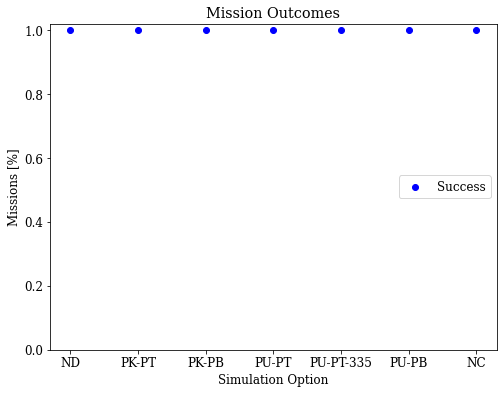

In [5]:
data = df.groupby(by='simOption').missionOutcome.value_counts(normalize=True).unstack(1).reset_index()
current = ['TARGET FOUND', 'TIME LIMIT EXCEEDED', 'ALL ROBOTS DEAD']
new = ['Success', 'Cutoff', 'Abort']
existing = ['simOption']
for i in range(len(current)): 
    if current[i] in data.columns:
        data.rename(columns={current[i]: new[i]}, inplace=True)
        existing.append(new[i])


data = data[existing]

data = reorder_xtick(data, x_tick_marks)
fig, ax = plt.subplots(1,1)

marker = ['o', 's', '^']
color = ['b', 'k', 'r']
for i, col in enumerate([c for c in data.columns if c != 'simOption']): 
    plt.scatter(data.simOption, data[col], label=col, marker=marker[i], c=color[i])
plt.legend(loc='right')
plt.xlabel('Simulation Option')
plt.ylabel('Missions [%]')
plt.ylim(0, 1.02)
plt.title('Mission Outcomes')
plt.savefig('plots/missionOutcomes.png')

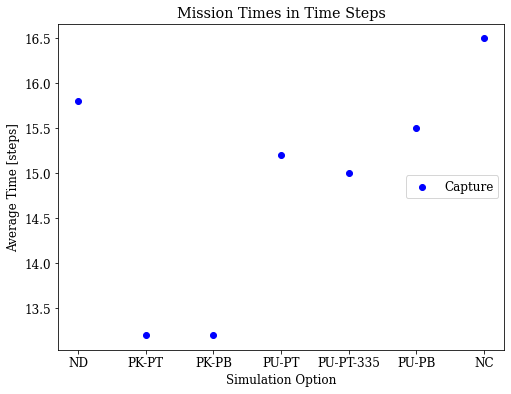

In [6]:
data = df.groupby(by=['simOption', 'missionOutcome']).timeStep.mean().unstack(1).reset_index()
data.rename(columns={'ALL ROBOTS DEAD': 'Abort', 'TARGET FOUND': 'Capture', 'TIME LIMIT EXCEEDED': 'End'}, inplace=True)
data = reorder_xtick(data, x_tick_marks)

marker = ['o', 's', '^']
color = ['b', 'k', 'r']
for i, col in enumerate([c for c in data.columns if c != 'simOption']): 
    plt.scatter(data.simOption, data[col], label=col, marker=marker[i], c=color[i])
plt.legend(loc='right')
plt.xlabel('Simulation Option')
plt.ylabel('Average Time [steps]')
plt.title('Mission Times in Time Steps')
plt.savefig('plots/missionTimes_timeSteps.png')

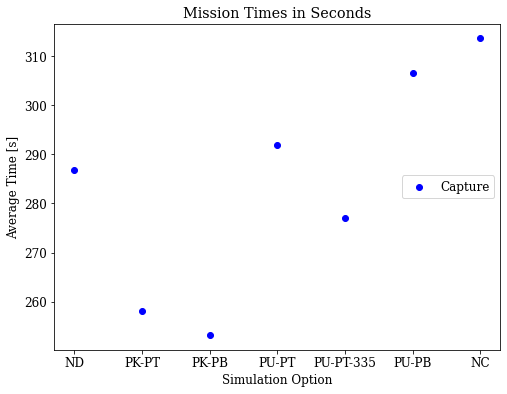

In [7]:
data = df.groupby(by=['simOption', 'missionOutcome']).simTime.mean().unstack(1).reset_index()
data.rename(columns={'ALL ROBOTS DEAD': 'Abort', 'TARGET FOUND': 'Capture', 'TIME LIMIT EXCEEDED': 'End'}, inplace=True)
data = reorder_xtick(data, x_tick_marks)

marker = ['o', 's', '^']
color = ['b', 'k', 'r']
for i, col in enumerate([c for c in data.columns if c != 'simOption']): 
    plt.scatter(data.simOption, data[col], label=col, marker=marker[i], c=color[i])
plt.legend(loc='right')
plt.xlabel('Simulation Option')
plt.ylabel('Average Time [s]')
plt.title('Mission Times in Seconds')
plt.savefig('plots/missionTimes_sec.png')

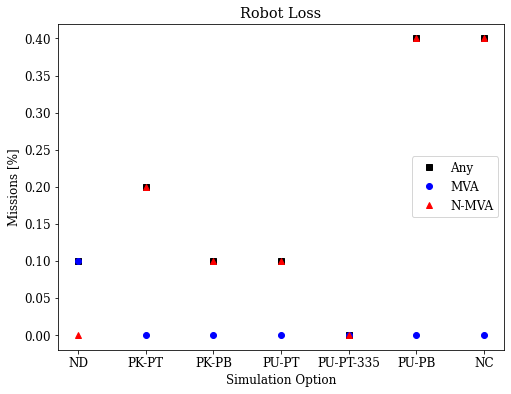

In [69]:
loss_df = df[['simOption', 'robotDeathLocation']]
dic = {}
for name, group in loss_df.groupby('simOption'): 
    dic[name] = len(group)
    
loss_df['Any'] = loss_df['robotDeathLocation'].apply(lambda x: 1 if any(i for i in x) else 0)
loss_df['MVA'] = loss_df['robotDeathLocation'].apply(lambda x: 1 if x[0] else 0)
loss_df['N-MVA'] = loss_df['robotDeathLocation'].apply(lambda x: 1 if x[1] or x[2] else 0)
loss_df = loss_df.groupby('simOption')['Any', 'MVA', 'N-MVA'].sum().reset_index()
loss_df['total'] = loss_df['simOption'].map(dic)
for i in ['Any', 'MVA', 'N-MVA']: 
    loss_df[i] = loss_df.apply(lambda x: x[i]/x['total'], axis=1)

loss_df = loss_df.drop(['total'], axis=1)
loss_df = reorder_xtick(loss_df, x_tick_marks)

marker = ['s', 'o', '^']
color = ['k', 'b', 'r']
for i, col in enumerate([c for c in loss_df.columns if c != 'simOption']): 
    plt.plot(loss_df.simOption, loss_df[col], linestyle='none', marker=marker[i], label=col, c=color[i])
plt.legend(loc='right')
plt.xlabel('Simulation Option')
plt.ylabel('Missions [%]')
plt.title('Robot Loss')
plt.savefig('plots/robotLoss.png')

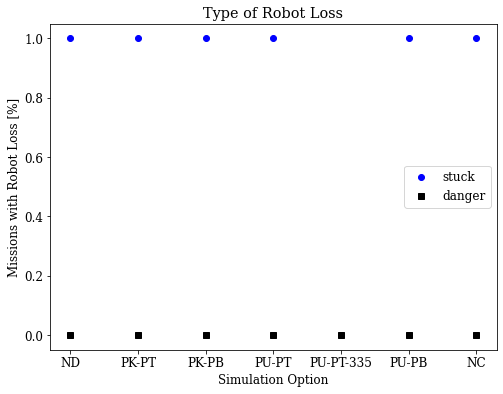

In [68]:
losstype_df = df[['simOption', 'robotDeathCause']]
dic = {}
for name, group in losstype_df.groupby('simOption'): 
    dic[name] = len(group)
    
losstype_df['stuck'] = losstype_df['robotDeathCause'].apply(lambda x: 1 if any(i == 'Stuck' for i in ast.literal_eval(x)) else 0)
losstype_df['danger'] = losstype_df['robotDeathCause'].apply(lambda x: 1 if any(i == 'Danger' for i in ast.literal_eval(x)) else 0)
losstype_df = losstype_df.groupby('simOption')['stuck', 'danger'].sum().reset_index()

losstype_df['total'] = losstype_df['stuck'] + losstype_df['danger']
for i in ['stuck', 'danger']: 
    losstype_df[i] = losstype_df.apply(lambda x: x[i]/x['total'] if x['total'] != 0 else x[i], axis=1)
losstype_df = reorder_xtick(losstype_df, x_tick_marks)
losstype_df = losstype_df.drop(['total'], axis=1)

marker = ['o', 's', '^']
color = ['b', 'k', 'r']
for i, col in enumerate([c for c in losstype_df.columns if c != 'simOption']): 
    plt.plot(losstype_df.simOption, losstype_df[col], linestyle='none', marker=marker[i], label=col, c=color[i])
plt.legend(loc='right')
plt.xlabel('Simulation Option')
plt.ylabel('Missions with Robot Loss [%]')
plt.title('Type of Robot Loss')
plt.savefig('plots/robotLossType.png')